In [184]:
from sklearn import metrics
import pandas as pd
import numpy as np
import datetime
#from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor
from sklearn.svm import SVC
# import pyfolio as pf
# from finrl.plot import backtest_plot
# from sklearn.svm import SVC

In [2]:
BIO = pd.read_csv("phase3_data/bio.csv")
BIO = BIO.loc[:, 'Report Date': 's_diff']
BIO['Report Date'] = pd.to_datetime(BIO['Report Date'])
all_date_column = BIO['Report Date']

In [3]:
BIO['Return'] = BIO['Stock price'].pct_change()
BIO['Stock price'] = BIO['Stock price'].shift(-1)
BIO['Y_boolean'] = BIO['Y_boolean'].shift(-1)
BIO['Return'] = BIO['Return'].shift(-1)
BIO = BIO.dropna()


In [4]:
# function to select data given date window
def window(start, end, df, all_date_column):
    '''
    Given a start and end date, return df with data only
    from that period
    
    Inputs:
        start/end: start and end dates
            ex: start = '2022-01-23' ('YYYY-MM-DD')
        df: pd dataframe
        date: pd series with dates of all possible dates in data
    
    Returns: pd dataframe
    '''

    date_column = all_date_column[all_date_column.between(start, end, inclusive='both')]
    df = pd.concat([date_column, df], axis = 1, join="inner")
    df = df.iloc[:, 1:]

    return df

In [119]:
def feature_selection_FS(training_dataset, testing_dataset, bar):
    """
    find the important feature using Fishers' score
    """

    X = training_dataset.iloc[:, 3:]
    Y_price = training_dataset['Stock price']
    Y_dummy = training_dataset['Y_boolean']
    date_train = training_dataset['Report Date']
    date_test = testing_dataset['Report Date']

    ranks = fisher_score.fisher_score(X.to_numpy(), Y_dummy)
    feat_importances = pd.Series(ranks, training_dataset.columns[3:])
#     feat_importances.plot(kind='barh', color ="teal")
#     plt.show()
    
    feat_selected = feat_importances.to_frame('importance')
    # select importance > than bar
    feat_selected = feat_selected[feat_selected['importance'] > bar]
    select_feature_lst = ['Report Date', 'Stock price', 'Y_boolean'] + list(feat_selected.index)
    
    return training_dataset[select_feature_lst], testing_dataset[select_feature_lst]
    
    
    

In [120]:
def feature_selection_IG(training_dataset, testing_dataset, bar):
    """
    find the important feature using IG method
    """

    X = training_dataset.iloc[:, 3:]
    Y_price = training_dataset['Stock price']
    Y_dummy = training_dataset['Y_boolean']
    date_train = training_dataset['Report Date']
    date_test = testing_dataset['Report Date']
    importances = mutual_info_classif(X, Y_dummy, random_state=1241)
    feat_importances = pd.Series(importances, training_dataset.columns[3:])
    feat_selected = feat_importances.to_frame('importance')
    # select importance > than bar
    feat_selected = feat_selected[feat_selected['importance'] > bar]
    select_feature_lst = ['Report Date', 'Stock price', 'Y_boolean'] + list(feat_selected.index)
    
    return training_dataset[select_feature_lst], testing_dataset[select_feature_lst]
    

In [124]:
def test_feature_select(training_dataset, validate_dataset):
    """
    check the performance of the current selected: use only training dataset accuracy 
    """
    # run baseline logit
    logit = LogisticRegression(solver = 'lbfgs', random_state=1241)
    X = training_dataset.iloc[:, 3:]
    Y_dummy = training_dataset['Y_boolean']
    logit.fit(X, Y_dummy)
    Y_dummy_validate = validate_dataset['Y_boolean']
    X_validate = validate_dataset.iloc[:, 3:]
    Y_pred = logit.predict(X_validate)

    score = accuracy_score(Y_dummy_validate, Y_pred)
    return score

In [135]:
# collect all date
date_starts = []
date = datetime.datetime(2020, 3, 2)
date_starts.append(date)

for idx in range(19):#range(722):
    date += datetime.timedelta(days=30)
    date_starts.append(date)
    


In [297]:
def phase_3_modeling(date_starts, full_data, all_date_column, model_name):
    """
    modeling for phase 3
    """
    features_selected = []
    results = {}
    best_model = {}
    all_other_model = {}

    for train_date_start in date_starts:
    #     print(train_date_start)
        train_date_end = train_date_start + datetime.timedelta(days=120)
        validate_date_start = train_date_end + datetime.timedelta(days=1)
        validate_date_end = validate_date_start + datetime.timedelta(days=60)
        test_date_start = validate_date_end + datetime.timedelta(days=1)
        test_date_end = test_date_start + datetime.timedelta(days=30)

        train_data = window(train_date_start, train_date_end, full_data, all_date_column)
        validate_data = window(validate_date_start, validate_date_end, full_data, all_date_column)
        test_data = window(test_date_start, test_date_end, full_data, all_date_column)

        bars_FS = range(0, 3, 7)
        bars_IG = np.arange(0, 0.01, 0.02)

        best_accuracy = 0
        best_bar = []
        best_features = []

        for bar_FS in bars_FS:
            for bar_IG in bars_IG:

                try:
                    train_BIO_selected, validate_BIO_selected = feature_selection_FS(train_data, validate_data, bar_FS)
                    train_BIO_selected, validate_BIO_selected = feature_selection_IG(train_BIO_selected, validate_BIO_selected, bar_IG)
                    score = test_feature_select(train_BIO_selected, validate_BIO_selected)
#                     print(score)
                    if score > best_accuracy:
#                         current_train = train_BIO_selected
#                         current_validate = validate_BIO_selected
                        best_accuracy = score
                        best_bar = [bar_FS, bar_IG]
                        best_features = train_BIO_selected.iloc[:,3:].columns
                except:
                    continue

        X_train = train_data[best_features]
        X_validate = validate_data[best_features]
        X_test = test_data[best_features]
        y_dummy_train = train_data['Y_boolean']
        y_price_train = train_data['Stock price']
        y_dummy_validate = validate_data['Y_boolean']
        y_price_validate = validate_data['Stock price']
        y_dummy_test = test_data['Y_boolean']
        y_price_test= test_data['Stock price']
        other_test, best, train_results, test_results, params, param_name, prediction_others, prediction_best = train_model(model_name, X_train, X_validate, y_dummy_train, y_price_train, y_dummy_validate, y_price_validate, X_test, y_dummy_test, y_price_test)
        
        results[train_date_start] = [(test_date_start, test_date_end)]
        results[train_date_start].append(train_results) 
        results[train_date_start].append(test_results) 
        results[train_date_start].append(params) 
        results[train_date_start].append(param_name) 
        best_model[test_date_start] = [(test_date_start, test_date_end)]
        best_model[test_date_start] = best
        all_other_model[test_date_start] = [(test_date_start, test_date_end)]
        all_other_model[test_date_start] = other_test
    return all_other_model, results, best_model, prediction_others, prediction_best

In [229]:
def plot_graph(model_name, all_other_models, best_models):
    """
    """
    best_model = best_models[model_name]
    all_other_model = all_other_models[model_name]
    x_axis = list(best_model.keys())
    y_best = [item[0] for item in list(best_model.values())]
    label_num = list(all_other_model.values())[0][-1]
    label_text = list(all_other_model.values())[0][-2]
    
    y_0 = [item[0] for item in list(all_other_model.values())]
    y_1 = [item[1] for item in list(all_other_model.values())]
    y_2 = [item[2] for item in list(all_other_model.values())]
    y_3 = [item[3] for item in list(all_other_model.values())]
    y_4 = [item[4] for item in list(all_other_model.values())]
    y_5 = [item[5] for item in list(all_other_model.values())]
    y_6 = [item[6] for item in list(all_other_model.values())]
    y_7 = [item[7] for item in list(all_other_model.values())]
    y_8 = [item[8] for item in list(all_other_model.values())]
    
    plt.plot(x_axis, y_best, label = "best_acc", marker="o")
    plt.scatter(x_axis, y_0, label = f"{label_text}: {label_num[0]}")
    plt.scatter(x_axis, y_1, label = f"{label_text}: {label_num[1]}")
    plt.scatter(x_axis, y_2, label = f"{label_text}: {label_num[2]}")
    plt.scatter(x_axis, y_3, label = f"{label_text}: {label_num[3]}")
    plt.scatter(x_axis, y_4, label = f"{label_text}: {label_num[4]}")
    plt.scatter(x_axis, y_5, label = f"{label_text}: {label_num[5]}")
    plt.scatter(x_axis, y_6, label = f"{label_text}: {label_num[6]}")
    plt.scatter(x_axis, y_7, label = f"{label_text}: {label_num[7]}")
    plt.scatter(x_axis, y_8, label = f"{label_text}: {label_num[8]}")
    
    plt.xlabel("time windows", fontsize=16)
    plt.ylabel("accuracy", fontsize=16)
    plt.title(model_name)
    plt.legend(loc = 'lower left')

In [298]:
# train model
def train_model(model_name, X_train, X_validate, y_train_class, y_train_price, y_validate_class, y_validate_price, X_test, y_test_class, y_test_price):
    '''
    Train model with different hyperparameter values and plot results
    '''
    #train_results = {}
    #validate_results = {}
    train_results = []
    validate_results = []
    val = None
    best_acc = 0
    best = [0,0,0,0]
    all_test = []
    prediction_best = []
    prediction_others = []
    
    if model_name == "logit":
        params = [.001, .01, 0.05, 0.5, 1, 2.5, 5,7.5, 10]
        y_train = y_train_class
        y_validate = y_validate_class
        y_test = y_test_class
    elif model_name == "sgdc" or model_name == 'sgdr':
        params = [0.0001, .001, .01, 0.05, .1, 0.15, .2, .3, .4,.5, 1]
        if model_name == 'sgdc':
            y_train = y_train_class
            y_validate = y_validate_class
            y_test = y_test_class
        else:
            y_train = y_train_price
            y_validate = y_validate_price
            y_test = y_test_price
    elif model_name == 'GradientBoostingClassifier':
        params = [0.0001, .001, .01, .1, .2, .3, .4,.5, 1]
        #model = GradientBoostingClassifier(learning_rate = val, random_state=123)
        y_train = y_train_class
        y_validate = y_validate_class
        y_test = y_test_class
    elif model_name == 'rfc' or model_name == 'rfr':
        params = [5, 10, 25, 50, 75, 90, 100, 150, 200]
        if model_name == 'rfc':
            #model = RandomForestClassifier(n_estimators=val, random_state=123)
            y_train = y_train_class
            y_validate = y_validate_class
            y_test = y_test_class
        else:
            #model = RandomForestRegressor(n_estimators=val, random_state=123)
            y_train = y_train_price
            y_validate = y_validate_price
            y_test = y_test_price
    elif model_name == 'svm':
        params = [.001, 0.005, .01, 0.05, 0.1,.5, 1, 2.5, 5]
        model = SVC(C=val, random_state=123)
        y_train = y_train_class
        y_validate = y_validate_class
        y_test = y_test_class
    else: # knn
        params = [1, 2, 3, 5, 7, 10, 12, 15, 20]
        model = KNeighborsClassifier(n_neighbors=val)
        y_train = y_train_class
        y_validate = y_validate_class
        y_test = y_test_class
    for val in params:
        if model_name == 'logit':
            model = LogisticRegression(C = val, random_state=123)
            param_name = 'C'
        elif model_name == 'sgdc':
            model = SGDClassifier(alpha=0.0001, epsilon=0.01, eta0 = val, max_iter = 10000, random_state=123)
            param_name = 'eta0'
        elif model_name == 'sgdr':
            model = SGDRegressor(alpha=0.0001, epsilon=0.01, eta0 = val, max_iter = 10000, random_state=123)
            param_name = 'eta0'
        elif model_name == 'GradientBoostingClassifier':
            model = GradientBoostingClassifier(learning_rate = val, random_state=123)
            param_name = 'learning rate'
        elif model_name == 'rfc': 
            model = RandomForestClassifier(n_estimators=val, random_state=123)
            param_name = 'n_estimators'
        elif model_name == 'rfr':
            model = RandomForestRegressor(n_estimators=val, random_state=123)
            param_name = 'n_estimators'
        elif model_name == 'svm':
            model = SVC(C=val, random_state=123)
            param_name = 'C'
        else:
            model = KNeighborsClassifier(n_neighbors=val)
            param_name = "n_neighbors"
        
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_validate_pred = model.predict(X_validate)
        y_test_pred = model.predict(X_test)
        if model_name == 'sgdr' or model_name == 'rfr':
            #return y_validate_pred, y_validate, params
            validate_acc = np.mean((y_validate_pred - y_validate)/y_validate)
            test_acc = np.mean((y_test_pred - y_test)/y_test)
            train_acc = np.mean((y_train_pred - y_train)/y_train)
            if validate_acc > best_acc:
                best_acc = validate_acc
                best[0] = test_acc
                best[1] = val
                best[2] = param_name
                best[3] = y_test_pred
                prediction_best = y_test_pred
        else:
            train_acc = metrics.accuracy_score(y_train, y_train_pred)
            validate_acc = metrics.accuracy_score(y_validate, y_validate_pred)
            test_acc = metrics.accuracy_score(y_test, y_test_pred)
            if validate_acc > best_acc:
                best_acc = validate_acc
                best[0] = test_acc
                best[1] = val
                best[2] = param_name
                best[3] = y_test_pred
                prediction_best = y_test_pred
                
        all_test.append(test_acc)
        train_results.append(train_acc)
        validate_results.append(validate_acc)
    all_test.append(param_name)
    all_test.append(params)
    prediction_others.append(y_test_pred)   
    
    return all_test, best, train_results, validate_results, params, param_name, prediction_others, prediction_best


In [292]:
PRE = list(list(all_bests['rfc'].values())[1][-1])
REAL = BIO['Y_boolean'].loc[213:243].tolist() 
wrong = 0
for i in range(31):
    if PRE[i] != REAL[i]:
        wrong += 1
        
1 - wrong/31

In [300]:
# model_names = ['logit', 'sgdc', 'sgdr', 'GradientBoostingClassifier', 'rfc', 'rfr', 'svm', 'knn']
model_names = ['sgdr', 'rfr']
# full_datas = [BIO, ZTS]
date_starts = date_starts
full_data = BIO
all_bests = {}
all_others = {}
all_prediction_best = []
all_prediction_others = []
for model_name in model_names:
    all_other_model, results, best_model, prediction_others, prediction_best = phase_3_modeling(date_starts, full_data, all_date_column, model_name)
    all_bests[model_name] = best_model
    all_others[model_name] = all_other_model
    all_prediction_best.append(prediction_best)
    all_prediction_others.append(prediction_others)

In [301]:
all_prediction_best

[array([739.61729646, 739.57716149, 739.53702693, 739.50564378,
        739.25171371, 739.12877564, 587.97924773, 587.98333243,
        587.9956359 , 588.00793936, 588.03121448, 587.93238662,
        587.87580893, 587.37663365, 587.11268586, 587.12510475,
        587.13752349, 587.09649189, 587.87304535, 588.1056774 ,
        588.6330107 , 588.72856141, 588.82411208, 588.91966271,
        589.04645638, 588.91415253, 588.64830778, 588.84498884,
        589.1600498 , 589.16004181]),
 array([754.7550059 , 754.7550059 , 755.0400065 , 767.42600096,
        754.20600584, 745.24998778, 776.02067056, 783.73868408,
        783.73868408, 783.73868408, 784.37534992, 782.67534586,
        780.71266276, 780.98667806, 770.7379883 , 770.7379883 ,
        771.96799318, 734.20932214, 780.04867348, 755.18066814,
        726.72000734, 721.74200438, 721.74200438, 721.74200438,
        738.1220093 , 732.65800784, 713.3800049 , 713.3800049 ,
        720.04399414, 720.04399414])]

In [ ]:
 ['logit', 'sgdc', 'sgdr', 'GradientBoostingClassifier', 'rfc', 'rfr', 'svm', 'knn']

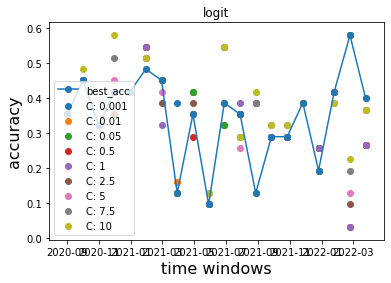

In [230]:
plot_graph('logit', all_others, all_bests)

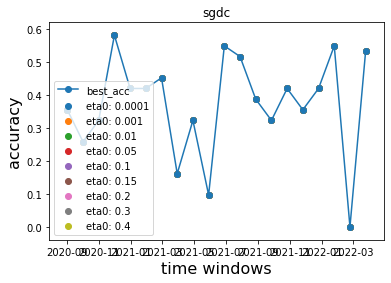

In [231]:
plot_graph('sgdc', all_others, all_bests)

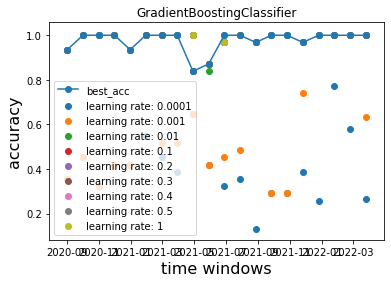

In [232]:
plot_graph('GradientBoostingClassifier', all_others, all_bests)

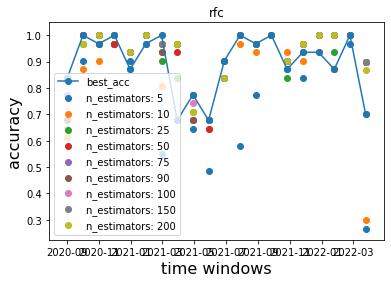

In [233]:
plot_graph('rfc', all_others, all_bests)

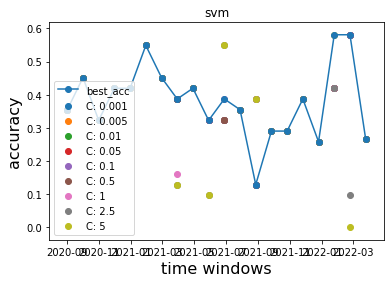

In [234]:
plot_graph('svm', all_others, all_bests)

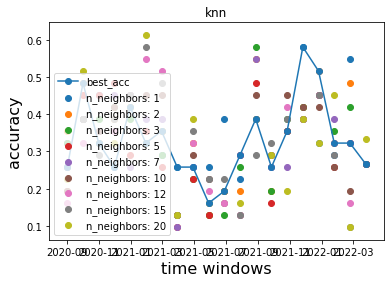

In [235]:
plot_graph('knn', all_others, all_bests)

{'logit': {datetime.datetime(2020, 9, 1, 0, 0): [0.3548387096774194,
   0.3548387096774194,
   0.3548387096774194,
   0.3548387096774194,
   0.3548387096774194,
   0.3548387096774194,
   0.3548387096774194,
   0.3548387096774194,
   0.3548387096774194,
   'C',
   [0.001, 0.01, 0.05, 0.5, 1, 2.5, 5, 7.5, 10]],
  datetime.datetime(2020, 10, 1, 0, 0): [0.45161290322580644,
   0.45161290322580644,
   0.45161290322580644,
   0.45161290322580644,
   0.45161290322580644,
   0.45161290322580644,
   0.45161290322580644,
   0.45161290322580644,
   0.4838709677419355,
   'C',
   [0.001, 0.01, 0.05, 0.5, 1, 2.5, 5, 7.5, 10]],
  datetime.datetime(2020, 10, 31, 0, 0): [0.3225806451612903,
   0.3225806451612903,
   0.3225806451612903,
   0.3225806451612903,
   0.3225806451612903,
   0.3225806451612903,
   0.3225806451612903,
   0.3225806451612903,
   0.3225806451612903,
   'C',
   [0.001, 0.01, 0.05, 0.5, 1, 2.5, 5, 7.5, 10]],
  datetime.datetime(2020, 11, 30, 0, 0): [0.41935483870967744,
   0.419354